In [73]:
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import importlib
import model
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import tqdm
import kan as k
import cheby
import kalnet as kal

In [74]:
importlib.reload(model)
importlib.reload(kal)
importlib.reload(k)
importlib.reload(cheby)

<module 'cheby' from 'd:\\Documents\\machinelearning\\ShiftedChebyKAN\\cheby\\__init__.py'>

In [75]:
from kan import KAN
from cheby import ChebyKANLayer

In [76]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)


train_data = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)


test_data = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)


train_loader = DataLoader(train_data, batch_size=32, shuffle=True)


test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [77]:
def test_continual_learning(model, epochs):

    accuracies = []

    for _ in tqdm.tqdm(range(10)):

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())
        for epoch in tqdm.tqdm(range(epochs)):
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        accuracy = correct / total
        accuracies.append(accuracy)

    return accuracies

In [78]:
def train_and_test_model(models, epochs=5):
    for model_dict in models:
        model_name = model_dict["name"]
        model = model_dict["model"]
        print(f"Training model: {model_name}")

        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

        train_losses = []
        test_losses = []
        accuracies = []

        for epoch in range(1, epochs + 1):
            epoch_loss = 0
            for images, labels in tqdm.tqdm(train_loader):
                optimizer.zero_grad()
                outputs = model(images)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            train_losses.append(epoch_loss / len(train_loader))

            test_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in tqdm.tqdm(test_loader):
                    outputs = model(images)
                    loss = nn.CrossEntropyLoss()(outputs, labels)
                    test_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            test_losses.append(test_loss / len(test_loader))
            accuracies.append(correct / total)

            print(
                "Model: {}, Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}".format(
                    model_name, epoch, train_losses[-1], test_losses[-1], accuracies[-1]
                )
            )

        model_dict["train_losses"] = train_losses
        model_dict["test_losses"] = test_losses
        model_dict["accuracies"] = accuracies

    return models

In [79]:
import matplotlib.pyplot as plt

def plot_model_metrics(loaded_results):
    names = [r['name'] for r in loaded_results]
    accuracies = [r['accuracies'] for r in loaded_results]
    total_params = [sum(p.numel() for p in model.parameters()) for model in [r['model'] for r in loaded_results]]

    colors = ['blue', 'green', 'red', 'purple', 'orange']  # Colors for 5 models

    # Plot accuracy comparison
    plt.figure(figsize=(10, 6))
    for i, name in enumerate(names):
        plt.plot(range(1, 11), accuracies[i], label=name, color=colors[i])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.legend()
    plt.show()

    test_losses = [r['test_losses'] for r in loaded_results]
    train_losses = [r['train_losses'] for r in loaded_results]

    num_epochs = len(test_losses[0])  
    num_models = len(names)
    bar_width = 0.15

    index = np.arange(num_epochs)

    plt.figure(figsize=(10, 6))

    for i in range(num_models):
        plt.bar(index + i * bar_width, np.array(train_losses[i]) - np.array(test_losses[i]), bar_width, color=colors[i], label=names[i])

    plt.xlabel('Epoch')
    plt.ylabel('Loss Difference (Train - Test)')
    plt.title("Convergence Speed Comparison")
    plt.xticks(index + bar_width, range(1, num_epochs + 1)) 
    plt.legend()
    plt.show()
    
    # Plot total parameters
    plt.figure(figsize=(10, 6))
    for i, name in enumerate(names): 
        plt.bar(name, total_params[i], color=colors[i], label=name)
        plt.text(i, total_params[i], str(total_params[i]), ha = 'center', va = 'bottom')

    plt.xlabel('Model')
    plt.ylabel('Total Parameters Comparison')
    plt.title('Total Parameters for Each Model')
    plt.legend()
    plt.show()

In [80]:
from model import GRAMLayer

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.LayerNorm(16),
            nn.ReLU(),
            nn.Linear(16, 10),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

class GRAM(nn.Module):
    def __init__(self):
        super(GRAM, self).__init__()
        self.layers = nn.Sequential(
            GRAMLayer(28 * 28, 32), GRAMLayer(32, 16), GRAMLayer(16, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

class MNISTChebyKAN(nn.Module):
    def __init__(self):
        super(MNISTChebyKAN, self).__init__()
        self.chebykan1 = ChebyKANLayer(28*28, 32, 4)
        self.ln1 = nn.LayerNorm(32)
        self.chebykan2 = ChebyKANLayer(32, 16, 4)
        self.ln2 = nn.LayerNorm(16)
        self.chebykan3 = ChebyKANLayer(16, 10, 4)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the images
        x = self.chebykan1(x)
        x = self.ln1(x)
        x = self.chebykan2(x)
        x = self.ln2(x)
        x = self.chebykan3(x)
        return x

kalnet = kal.KAL_Net([28*28, 32, 16, 10])

kan = KAN([28*28, 32, 16, 10])

In [81]:
models = [
    {"name": "KAN", "model": kan},
    {"name": "GRAM", "model": GRAM()},
    {"name": "Cheby", "model": MNISTChebyKAN()},
    {"name": "KALNET", "model": kalnet},
    {"name": "MLP", "model": MLP()},
]

In [82]:
import pickle
import os

if os.path.exists("latest_result.pkl"):
    with open("latest_result.pkl", "rb") as file:
        results = pickle.load(file)
else:
    results = train_and_test_model(models, epochs=10)

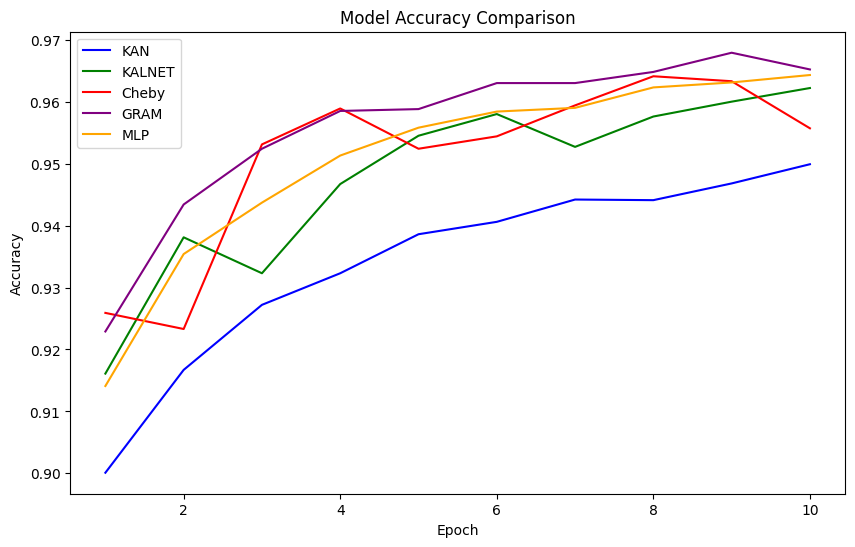

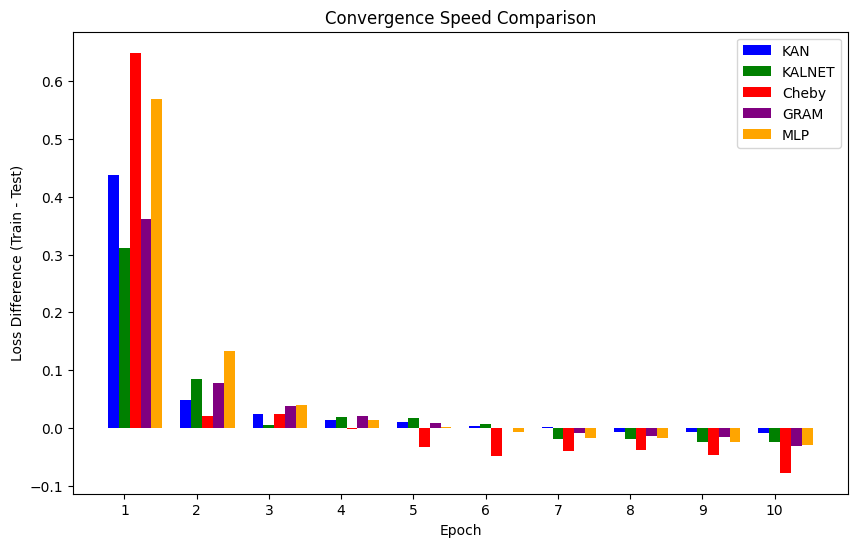

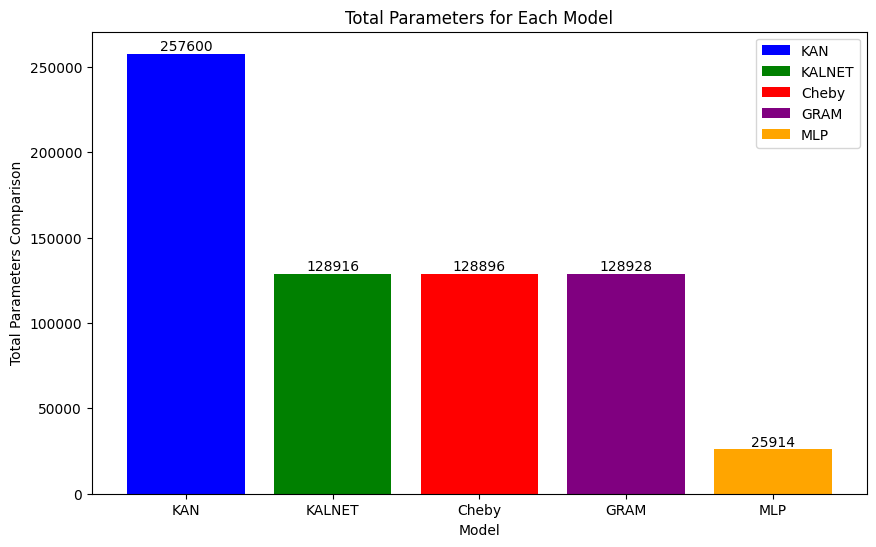

In [83]:
plot_model_metrics(results)